# Temporal Naive Bayes (TNB): Validação com Dados Sintéticos

## Objetivo
Implementar e validar o modelo Temporal Naive Bayes (TNB) que incorpora dependência temporal de primeira ordem entre medições sequenciais, comparando-o com o Naive Bayes clássico.

## Contexto Teórico
- **Naive Bayes Clássico**: Assume independência entre *features*  
  $$P(C_k | X) \propto P(C_k) \cdot \prod_{i=1}^{n} P(x_i | C_k)$$
  
- **Temporal Naive Bayes**: Incorpora dependência Markoviana  
  $$P(x_i^{(t)} | C_k, x_i^{(t-1)}) \sim \mathcal{N}(\mu_k + \alpha x_i^{(t-1)}, \sigma_k^2)$$


## Geração de Dados Sintéticos

### Modelo Autoregressivo (AR(1))
Para simular séries temporais com dependência temporal:  
$$x^{(t)} = \mu + \alpha x^{(t-1)} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$


**Parâmetros**:  
- `T = 50`: Comprimento das séries  
- `N_train = 200`, `N_test = 100`: Amostras por classe  
- Classes diferenciadas por médias (\(\mu_0 = 0.0\), \(\mu_1 = 2.0\))  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm  # para visualizar o progresso

# Configurações iniciais e semente para reprodutibilidade
np.random.seed(42)
T = 50            # Comprimento de cada série temporal
N_train = 200     # Número de séries por classe para treinamento
N_test = 100      # Número de séries por classe para teste

# Parâmetros verdadeiros para as classes:
# Classe 0:
mu0 = 0.0
sigma0 = 1.0
# Classe 1:
mu1 = 2.0
sigma1 = 1.0

# Valor de alpha utilizado para gerar os dados. Alpha representa o coeficiente de dependência temporal.
alpha_true = 0.8


# Geração de dados sintéticos

In [2]:
def generate_sequence(mu, sigma, alpha, T, x0=0):
    """
    Gera uma única sequência temporal, considerando a dependência do instante anterior.
    """
    x = np.zeros(T)
    x[0] = x0  # estado inicial
    for t in range(1, T):
        mean_t = mu + alpha * x[t-1]
        x[t] = np.random.normal(mean_t, sigma)
    return x

def generate_dataset(mu, sigma, alpha, T, N):
    """
    Gera um conjunto de dados composto por N sequências, de comprimento T.
    """
    data = []
    for _ in range(N):
        seq = generate_sequence(mu, sigma, alpha, T)
        data.append(seq)
    return np.array(data)

# Gerando os conjuntos de treinamento para as classes 0 e 1
X_train0 = generate_dataset(mu0, sigma0, alpha_true, T, N_train)
X_train1 = generate_dataset(mu1, sigma1, alpha_true, T, N_train)
y_train0 = np.zeros(N_train)
y_train1 = np.ones(N_train)

X_train = np.concatenate([X_train0, X_train1], axis=0)
y_train = np.concatenate([y_train0, y_train1], axis=0)

# Gerando os conjuntos de teste
X_test0 = generate_dataset(mu0, sigma0, alpha_true, T, N_test)
X_test1 = generate_dataset(mu1, sigma1, alpha_true, T, N_test)
y_test0 = np.zeros(N_test)
y_test1 = np.ones(N_test)

X_test = np.concatenate([X_test0, X_test1], axis=0)
y_test = np.concatenate([y_test0, y_test1], axis=0)


## Implementação do Temporal Naive Bayes

A modificação no Naive Bayes para incorporar a dependência temporal.
A equação utilizada para o TNB é:  

$$P(C_k | X^{(t)}) \propto P(C_k) \prod_{t=1}^{T} P(x^{(t)} | C_k,x^{(t-1)})$$

Utilizou-se a função `norm.logpdf` para calcular o log da densidade de probabilidade da distribuição normal com média $\mu + \alpha \cdot x^{t-1}$ e variância $\sigma^2$


In [3]:
def log_likelihood_TNB(x, mu, sigma, alpha):
    ll = 0.0
    for t in range(1, len(x)):
        mean_t = mu + alpha * x[t-1]
        ll += norm.logpdf(x[t], loc=mean_t, scale=sigma)
    return ll

def classify_sequence(seq, params_class0, params_class1, prior0=0.5, prior1=0.5):
    mu0, sigma0, alpha0 = params_class0
    mu1, sigma1, alpha1 = params_class1
    log_post0 = np.log(prior0) + log_likelihood_TNB(seq, mu0, sigma0, alpha0)
    log_post1 = np.log(prior1) + log_likelihood_TNB(seq, mu1, sigma1, alpha1)
    return 0 if log_post0 > log_post1 else 1

## Análise de Sensibilidade a Hiperparâmetros

### Efeito do Coeficiente $\alpha$
Como a acurácia varia quando alteramos o $\alpha$ assumido pelo modelo?  
- **Hipótese**: O desempenho máximo deve ocorrer próximo de $\alpha = 0.8$ (valor verdadeiro).

### Efeito do Ruído $\sigma$
Qual o impacto de sub/sobre-estimar a variância?

# Variação de $\alpha$
Ao variar o valor de $\alpha$ de 0 a 1.2, esperamos ver um pico próximo do valor verdadeiro ($\alpha_{true}$) se o modelo estiver capturando a dependência temporal corretamente.

Testando alpha: 100%|██████████| 25/25 [00:42<00:00,  1.68s/it]


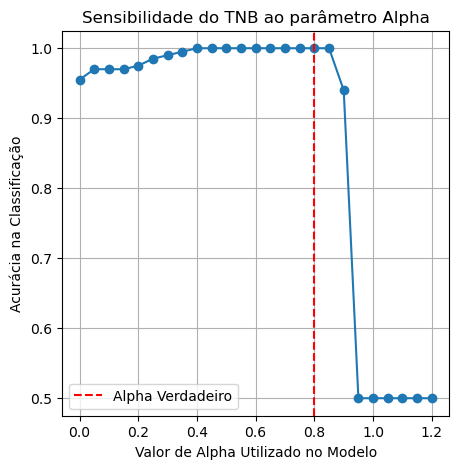

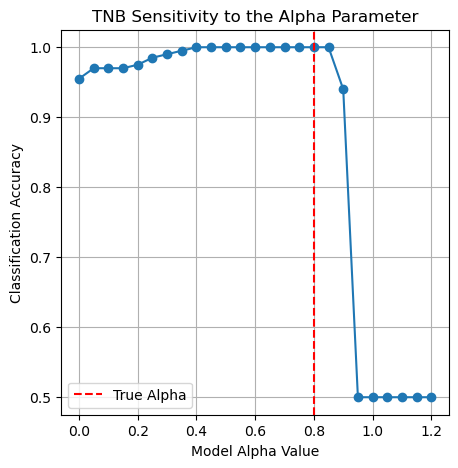

In [5]:
# Função para avaliar o classificador TNB dado um alpha candidato para a modelagem
def evaluate_classifier(X, y, mu0, sigma0, mu1, sigma1, alpha_candidate):
    params0 = (mu0, sigma0, alpha_candidate)
    params1 = (mu1, sigma1, alpha_candidate)
    y_pred = [classify_sequence(x, params0, params1) for x in X]
    return accuracy_score(y, y_pred)

# Testando sensibilidade em função do parâmetro alpha
alpha_values = np.linspace(0.0, 1.2, 25)  # varia de 0 (sem dependência) a 1.2
accuracies = []

for a in tqdm(alpha_values, desc="Testando alpha"):
    acc = evaluate_classifier(X_test, y_test, mu0, sigma0, mu1, sigma1, a)
    accuracies.append(acc)

# Visualizando os resultados para alpha
plt.figure(figsize=(5,5))
plt.plot(alpha_values, accuracies, marker='o', linestyle='-')
plt.axvline(alpha_true, color='red', linestyle='--', label='Alpha Verdadeiro')
plt.xlabel('Valor de Alpha Utilizado no Modelo')
plt.ylabel('Acurácia na Classificação')
plt.title('Sensibilidade do TNB ao parâmetro Alpha')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico em Inglês
plt.figure(figsize=(5, 5))
plt.plot(alpha_values, accuracies, marker='o', linestyle='-')
plt.axvline(alpha_true, color='red', linestyle='--', label='True Alpha')
plt.xlabel('Model Alpha Value')
plt.ylabel('Classification Accuracy')
plt.title('TNB Sensitivity to the Alpha Parameter')
plt.legend()
plt.grid(True)
plt.show()

# Monta o DataFrame e salva em CSV
df_alpha = pd.DataFrame({
    'alpha': alpha_values,
    'accuracy': accuracies
})
df_alpha.to_csv('alpha_sensitivity.csv', index=False)

# Variação de $\sigma$
Ao variar $\sigma$, analisamos a robustez do modelo quanto ao nível de ruído. Em nosso caso, os dados sintéticos são altamente diferenciáveis, logo a acurácia pode se manter constante (próxima de 1).

Testando sigma: 100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


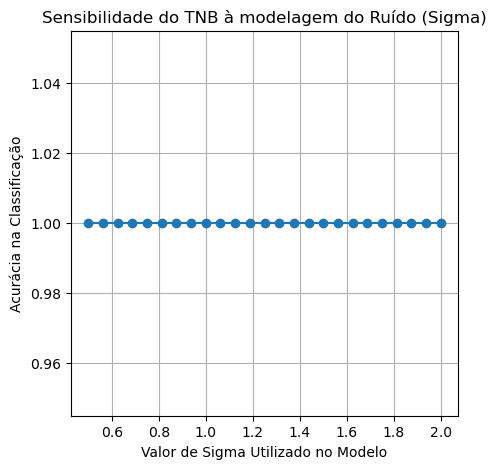

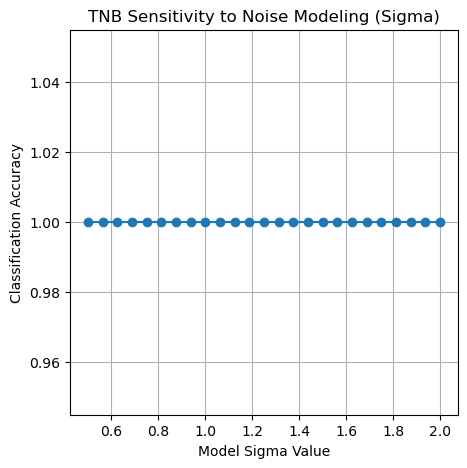

In [7]:
# Testando a influência da variância (sigma) na performance
sigma_test_values = np.linspace(0.5, 2.0, 25)
accuracies_sigma = []

for s in tqdm(sigma_test_values, desc="Testando sigma"):
    acc = evaluate_classifier(X_test, y_test, mu0, s, mu1, s, alpha_true)
    accuracies_sigma.append(acc)

# Visualizando os resultados para sigma
plt.figure(figsize=(5,5))
plt.plot(sigma_test_values, accuracies_sigma, marker='o', linestyle='-')
plt.xlabel('Valor de Sigma Utilizado no Modelo')
plt.ylabel('Acurácia na Classificação')
plt.title('Sensibilidade do TNB à modelagem do Ruído (Sigma)')
plt.grid(True)
plt.show()

# Gráfico em Inglês
plt.figure(figsize=(5, 5))
plt.plot(sigma_test_values, accuracies_sigma, marker='o', linestyle='-')
plt.xlabel('Model Sigma Value')
plt.ylabel('Classification Accuracy')
plt.title('TNB Sensitivity to Noise Modeling (Sigma)')
plt.grid(True)
plt.show()

# Monta o DataFrame e salva em CSV
df_sigma = pd.DataFrame({
    'sigma': sigma_test_values,
    'accuracy': accuracies_sigma
})
df_sigma.to_csv('sigma_sensitivity.csv', index=False)

# Cálculo de Acurácia, Matriz de Confusão e Relatório de Classificação

In [8]:
# Função para classificar o conjunto inteiro
def classify_dataset(X, params_class0, params_class1, prior0=0.5, prior1=0.5):
    y_pred = [classify_sequence(x, params_class0, params_class1, prior0, prior1) for x in X]
    return np.array(y_pred)

# Usando os parâmetros corretos para ambas as classes (alpha_true)
params0 = (mu0, sigma0, alpha_true)
params1 = (mu1, sigma1, alpha_true)

# Classifica o conjunto de teste
y_pred = classify_dataset(X_test, params0, params1)

# Cálculo das métricas
acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"])

print(f"Acurácia: {acc:.3f}")
print("Matriz de Confusão:")
print(conf_mat)
print("\nRelatório de Classificação:")
print(report)


Acurácia: 1.000
Matriz de Confusão:
[[100   0]
 [  0 100]]

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       1.00      1.00      1.00       100
    Classe 1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



# Plot da Curva ROC

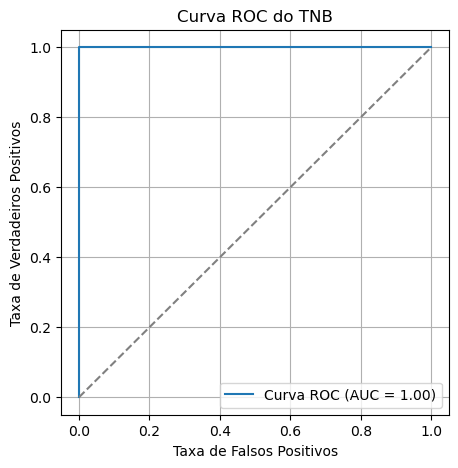

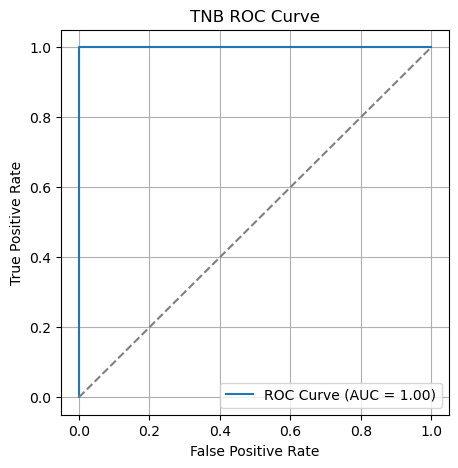

In [10]:
# Função para calcular o score a partir da diferença dos log-posteriors
def compute_scores(seq, params0, params1, prior0=0.5, prior1=0.5):
    log_post0 = np.log(prior0) + log_likelihood_TNB(seq, params0[0], params0[1], params0[2])
    log_post1 = np.log(prior1) + log_likelihood_TNB(seq, params1[0], params1[1], params1[2])
    return log_post1 - log_post0  # score: quanto maior, maior probabilidade da classe 1

scores = np.array([compute_scores(x, params0, params1) for x in X_test])
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC do TNB')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Gráfico em Inglês
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TNB ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Cria DataFrame e salva em CSV
df_roc = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})
df_roc.to_csv('roc_synthetic.csv', index=False)

# Análise de Sequências Específicas

Nesta seção, calculamos e exibimos diversas métricas de performance:

- Acurácia, Matriz de Confusão e Relatório de Classificação: Essas métricas mostram a taxa de acerto e os detalhes dos acertos/erros do modelo.

- Curva ROC: A ROC e a sua respectiva AUC indicam como o classificador separa as classes, mostrando a relação entre taxa de verdadeiros positivos e falsos positivos.

- Análise de Sequências: Visualizar a sequência real versus a média predita pelo modelo permite entender se o mecanismo temporal (onde a média é definida por $\mu + \alpha \cdot x^{t-1}$ está sendo efetivamente seguido.

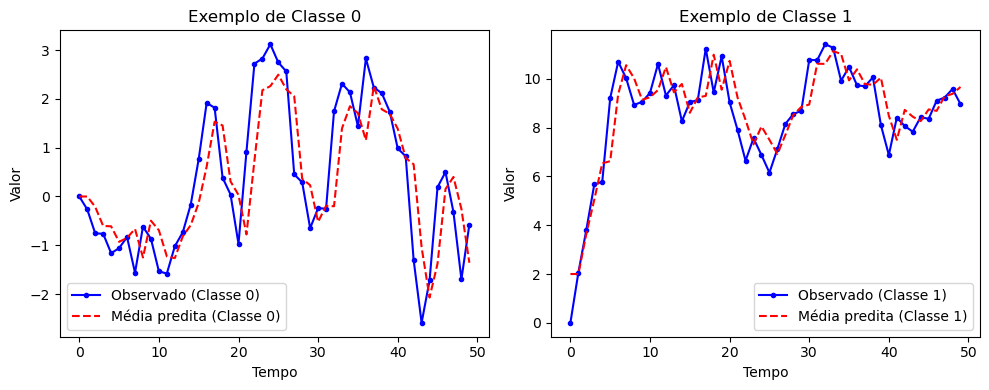

In [10]:
def plot_sequence(seq, params, label):
    T = len(seq)
    means = [params[0] + params[2] * seq[t-1] if t > 0 else params[0] for t in range(T)]
    plt.plot(range(T), seq, 'b.-', label=f'Observado ({label})')
    plt.plot(range(T), means, 'r--', label=f'Média predita ({label})')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    
# Exemplo: Uma sequência de cada classe
seq_example_0 = X_test[y_test == 0][0]
seq_example_1 = X_test[y_test == 1][0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_sequence(seq_example_0, params0, "Classe 0")
plt.title("Exemplo de Classe 0")

plt.subplot(1, 2, 2)
plot_sequence(seq_example_1, params1, "Classe 1")
plt.title("Exemplo de Classe 1")
plt.tight_layout()
plt.show()


# Comparação com o Naive Bayes Clássico (Baseline)

Nesta etapa, implementamos o Naive Bayes clássico que trata cada instância temporal de forma independente, ou seja, sem incorporar a dependência do valor anterior.
A fórmula de verossimilhança usada é:

$$P(C_k | X) \propto P(C_k) \cdot \prod_{i=1}^{n} P(x_i | C_k)$$

Em seguida, comparamos a acurácia do modelo clássico com a do TNB. No seu exemplo, o TNB apresentou 100% de acurácia enquanto o modelo clássico alcançou cerca de 95,5%, indicando a vantagem de incorporar a dependência temporal.

In [11]:
def log_likelihood_classic(x, mu, sigma):
    """
    Log-likelihood para o Naive Bayes clássico que ignora a dependência temporal.
    Aqui, para t=1 até T-1, utiliza uma média constante mu.
    """
    ll = sum(norm.logpdf(x[t], loc=mu, scale=sigma) for t in range(1, len(x)))
    return ll

def classify_sequence_classic(seq, mu0, sigma0, mu1, sigma1, prior0=0.5, prior1=0.5):
    log_post0 = np.log(prior0) + log_likelihood_classic(seq, mu0, sigma0)
    log_post1 = np.log(prior1) + log_likelihood_classic(seq, mu1, sigma1)
    return 0 if log_post0 > log_post1 else 1

def classify_dataset_classic(X, mu0, sigma0, mu1, sigma1, prior0=0.5, prior1=0.5):
    y_pred = [classify_sequence_classic(x, mu0, sigma0, mu1, sigma1, prior0, prior1) for x in X]
    return np.array(y_pred)

# Classificação com o Naive Bayes clássico
y_pred_classic = classify_dataset_classic(X_test, mu0, sigma0, mu1, sigma1)
acc_classic = accuracy_score(y_test, y_pred_classic)
print(f"Acurácia do Naive Bayes Clássico: {acc_classic:.3f}")


Acurácia do Naive Bayes Clássico: 0.955
